### Project Setup

In [1]:
!pip install seaborn
!pip install scipy
!pip install scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


### Citirea setului de date

In [2]:
# Citirea setului de date
df = pd.read_csv('dataset.csv')

### Filtrarea datelor

In [3]:
# Înlocuim -Infinity cu cel mai mic număr accesibil (substituting with the smallest representable number)
df.replace(-np.inf, np.finfo(np.float64).min, inplace=True)

# Înlocuim +Infinity cu cel mai mare număr accesibil (substituting with the largest representable number)
df.replace(np.inf, np.finfo(np.float64).max, inplace=True)

# Eliminăm rândurile care conțin NaN după înlocuire
df = df.dropna()

# 3.1. Explorarea Datelor (Exploratory Data Analysis)

## 1. Analiza Echilibrului de Clase

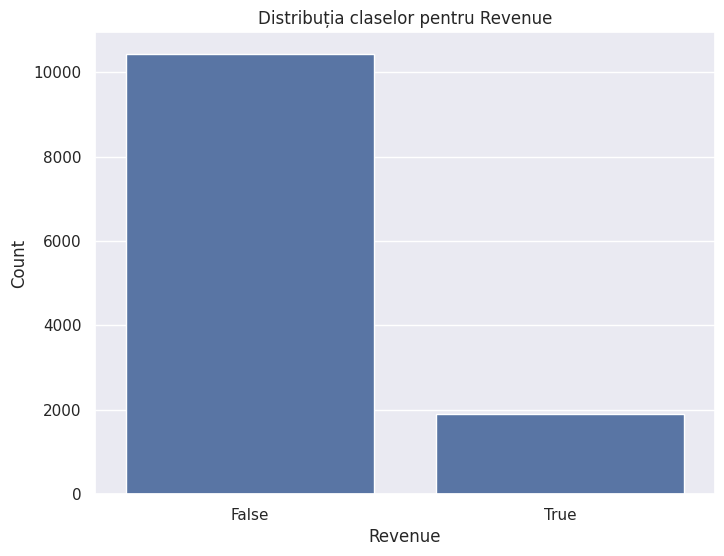

In [4]:
# Verificarea echilibrului claselor
plt.figure(figsize=(8, 6))
sns.countplot(x='Revenue', data=df)
plt.title('Distribuția claselor pentru Revenue')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

## 2. Vizualizarea Atributelor

### 2.A Atribute Numerice

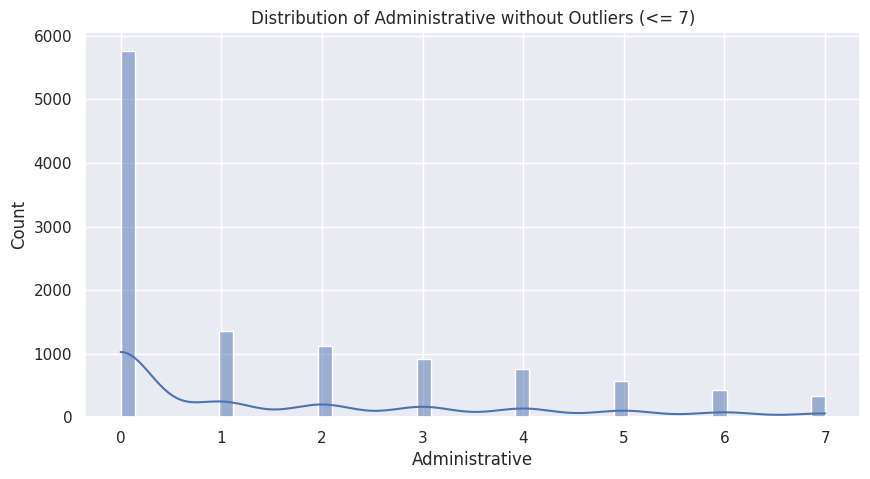

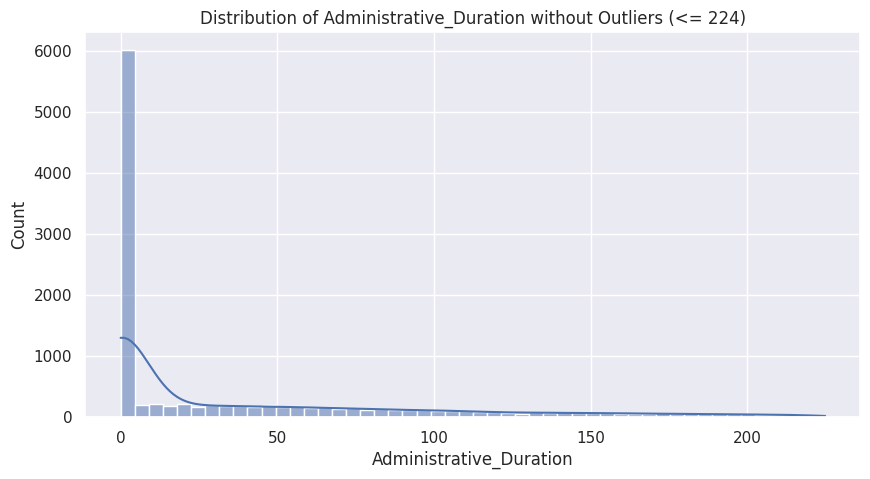

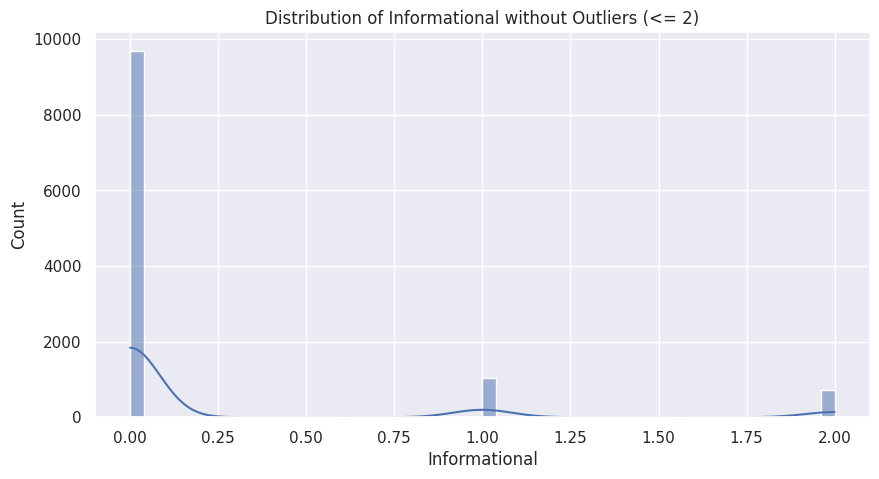

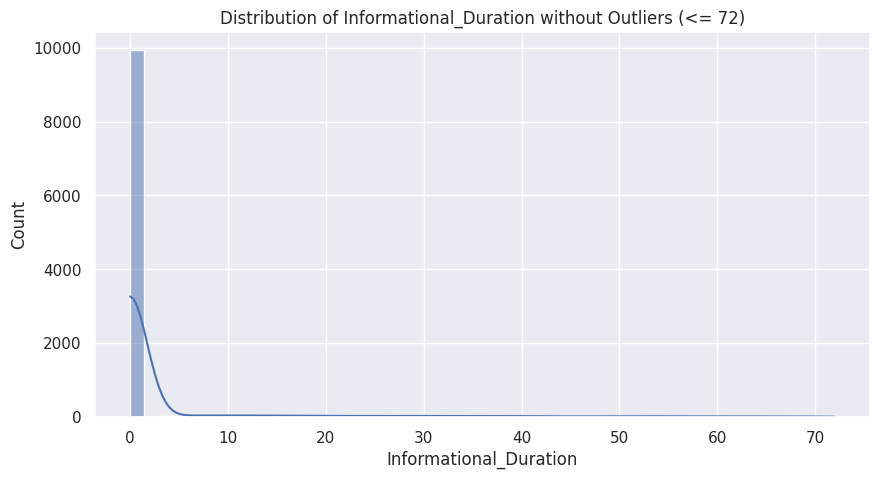

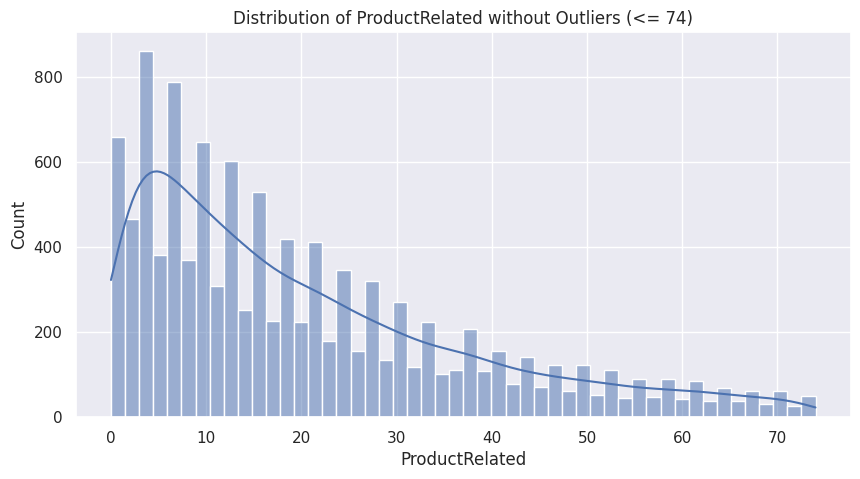

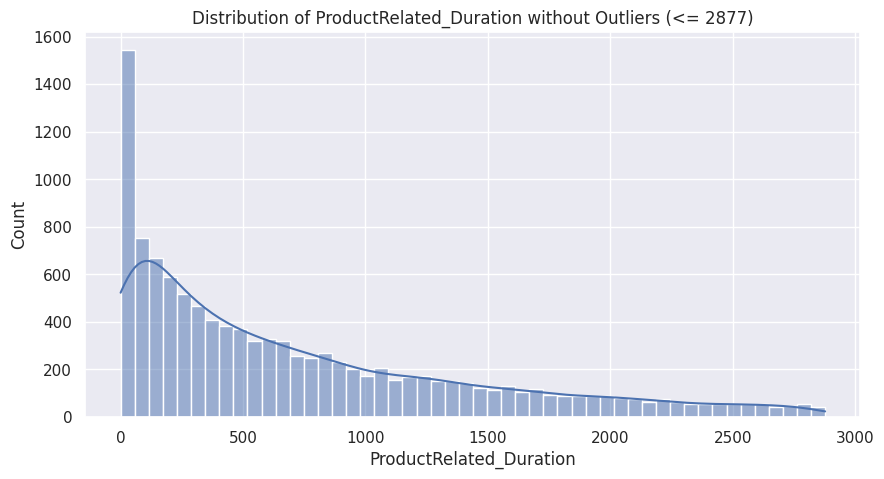

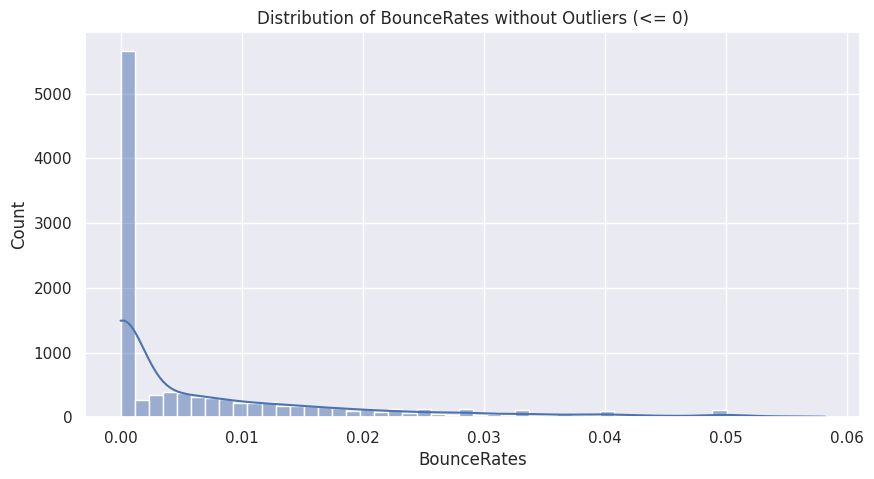

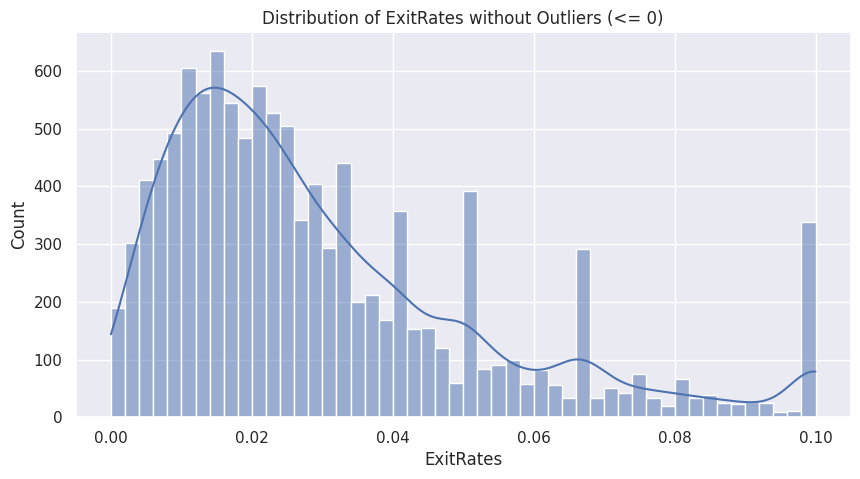

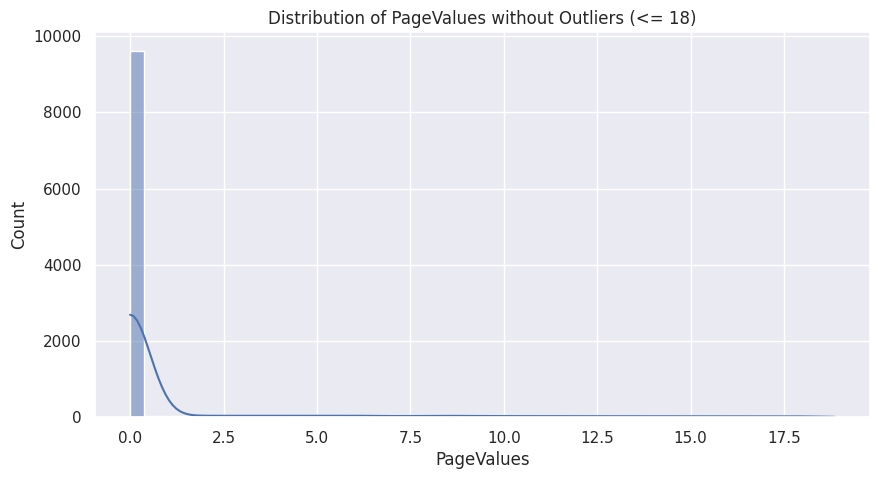

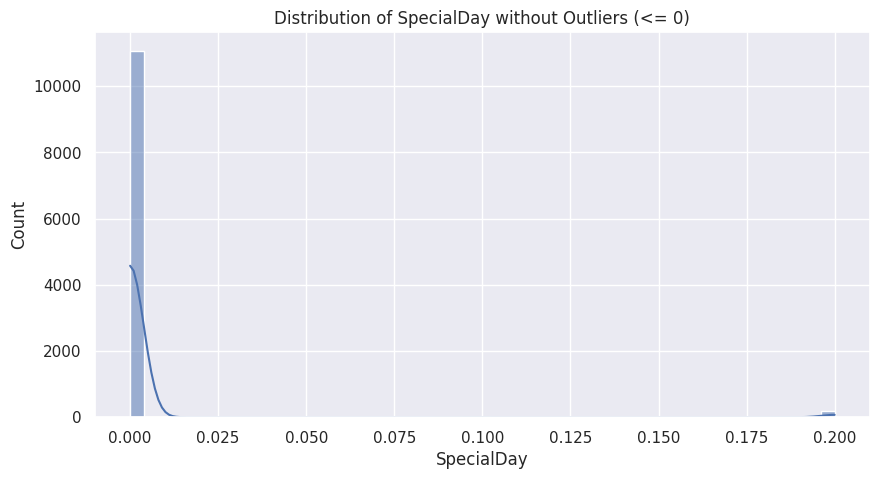

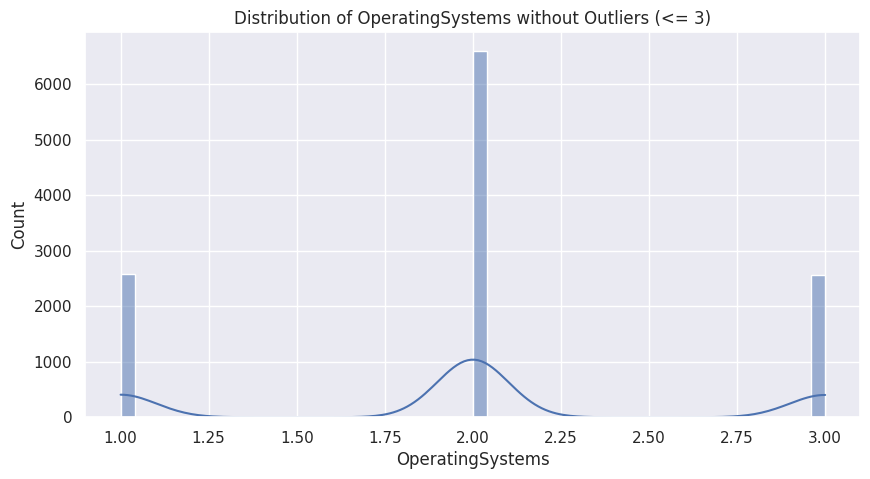

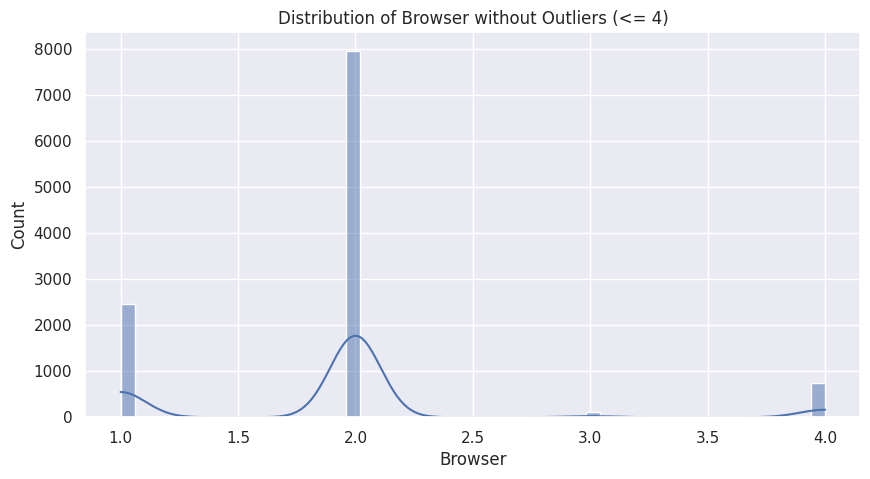

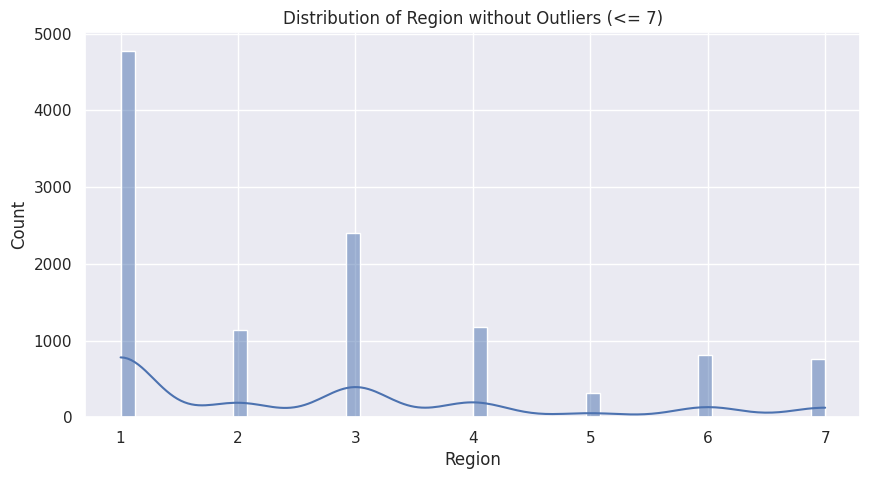

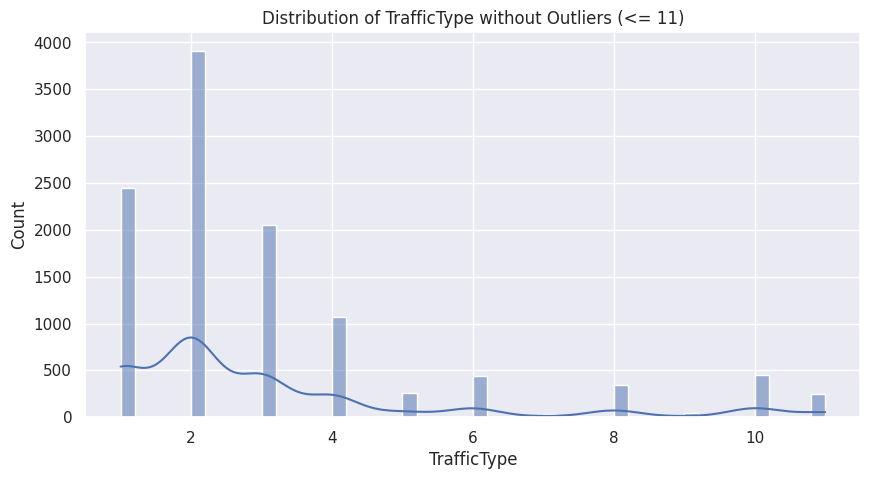

In [5]:
# Identificarea atributelor numerice
numeric_features = df.select_dtypes(include=[np.number]).columns
for feature in numeric_features:
    # Calculați percentilele cu granularitate de 10%
    percentiles = np.percentile(df[feature], np.arange(0, 101, 10))
    
    # Alegem pragul pentru a elimina outlierii (de exemplu, 90th percentile)
    threshold = percentiles[9]
    
    # Filtrați datele pentru a elimina outlierii
    filtered_data = df[df[feature] <= threshold]
    
    # Realizați un grafic pentru distribuția valorilor fără outlieri
    plt.figure(figsize=(10, 5))
    sns.histplot(filtered_data[feature], bins=50, kde=True)
    
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'Distribution of {feature} without Outliers (<= {int(threshold)})')
    plt.show()

### 2.A Atribute Categorice

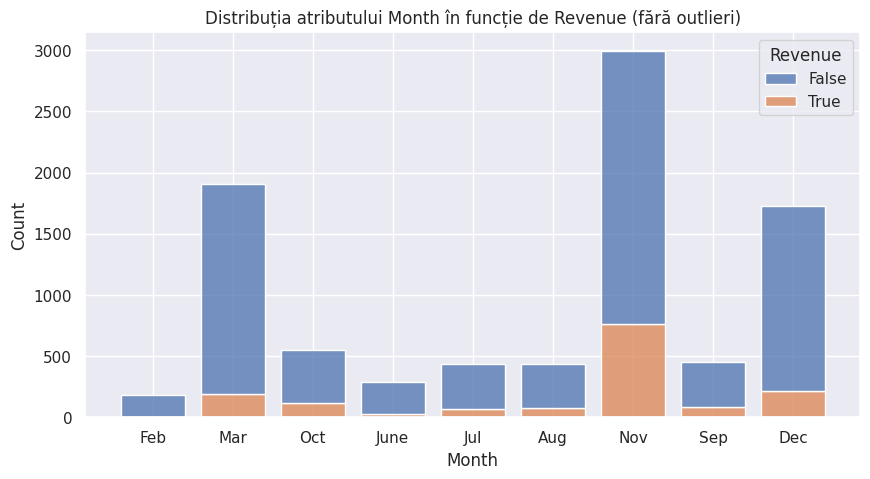

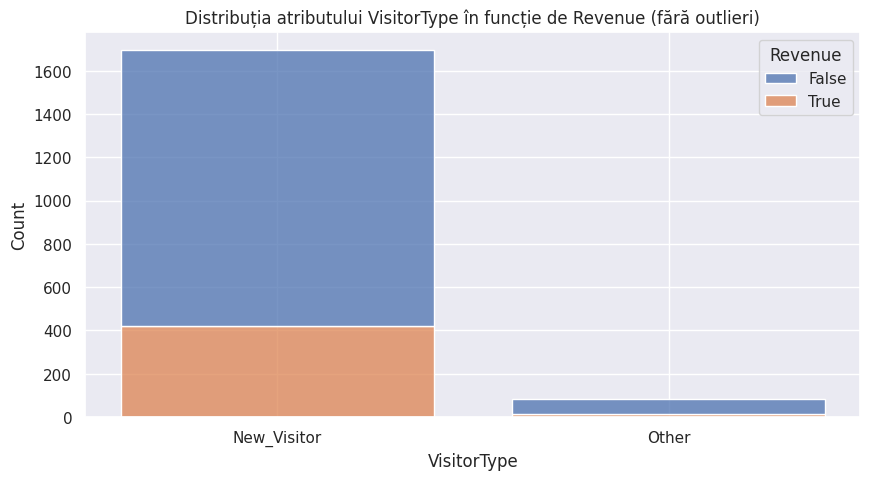

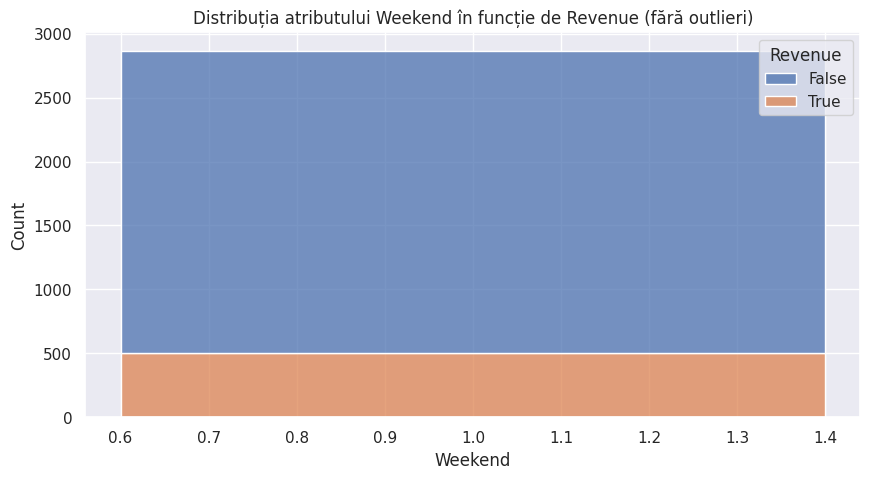

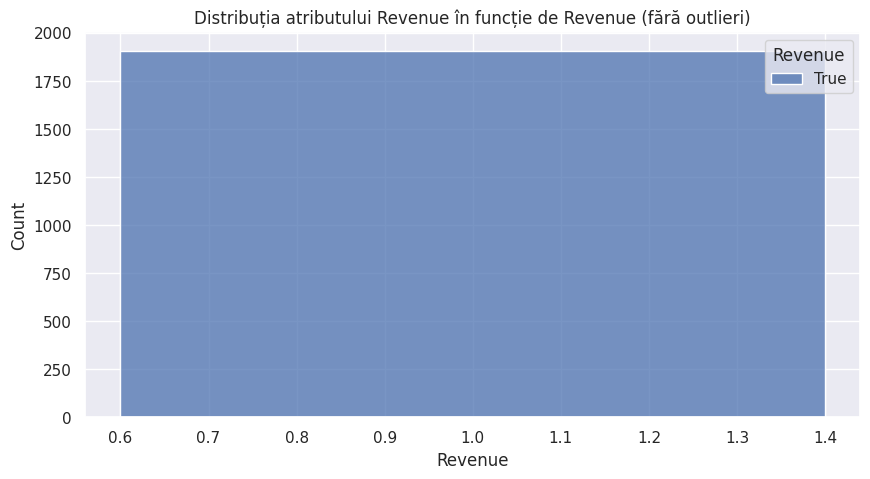

In [6]:
# Identificarea atributelor categorice
categorical_attributes = df.select_dtypes(exclude=np.number).columns.tolist()

for attribute in categorical_attributes:
    # Calculăm frecvența pentru fiecare categorie
    category_counts = df[attribute].value_counts()

    # Alegem un prag pentru a elimina categoriile cu o frecvență mai mare decât percentilele specificate (de exemplu, 90th percentile)
    threshold = np.percentile(category_counts, 90)

    # Filtrăm datele pentru a păstra doar categoriile cu frecvență sub prag
    df_filtered = df[df[attribute].isin(category_counts[category_counts <= threshold].index)]

    # Realizăm un grafic pentru distribuția categoriilor după eliminarea outlierilor
    plt.figure(figsize=(10, 5))
    sns.histplot(x=attribute, data=df_filtered, hue='Revenue', multiple='stack', shrink=0.8)
    plt.title(f'Distribuția atributului {attribute} în funcție de Revenue (fără outlieri)')
    plt.show()


## 3. Analiza Gradului de Corelare

### 3.A Atribute Numerice cu Coeficientul de Point-Biserial

                  Attribute  Correlation        P-Value
0            Administrative     0.138917   3.519760e-54
1   Administrative_Duration     0.093587   2.146514e-25
2             Informational     0.095200   3.174034e-26
3    Informational_Duration     0.070345   5.282871e-15
4            ProductRelated     0.158538   3.241187e-70
5   ProductRelated_Duration     0.152373   6.115338e-65
6               BounceRates    -0.150673   1.594198e-63
7                 ExitRates    -0.207071  1.662654e-119
8                PageValues     0.492569   0.000000e+00
9                SpecialDay    -0.082305   5.498934e-20
10         OperatingSystems    -0.014668   1.033943e-01
11                  Browser     0.023984   7.736888e-03
12                   Region    -0.011595   1.979426e-01
13              TrafficType    -0.005113   5.702434e-01




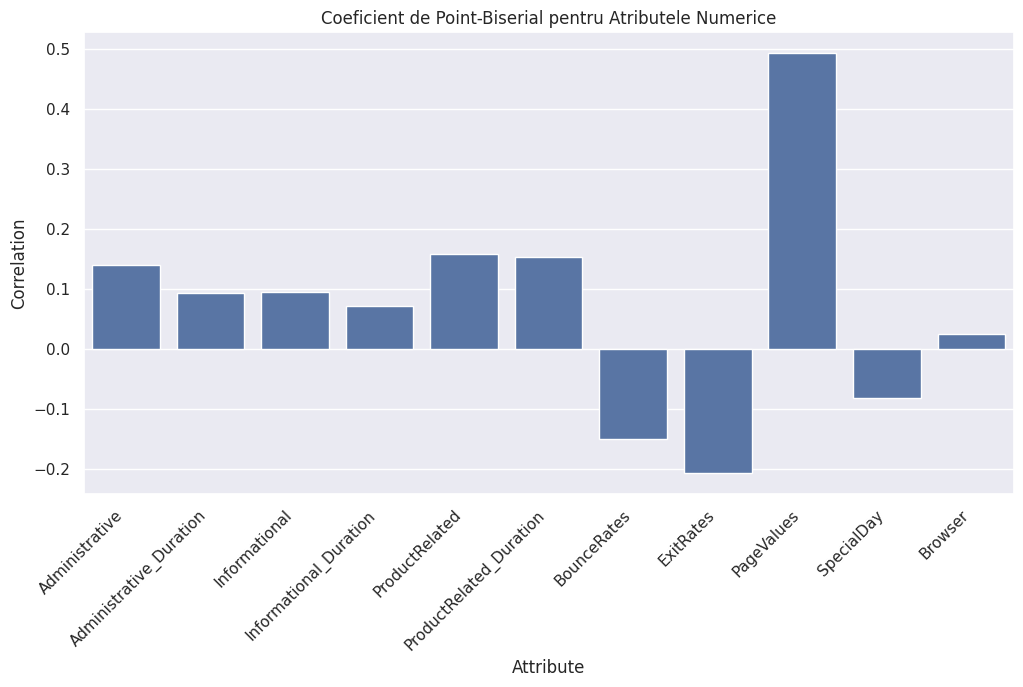

In [7]:
correlation_results_numeric = []

for attribute in numeric_features:
    if attribute != 'Revenue':
        correlation, p_value = pointbiserialr(df[attribute], df['Revenue'])
        correlation_results_numeric.append({'Attribute': attribute, 'Correlation': correlation, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_numeric = pd.DataFrame(correlation_results_numeric)
print(correlation_df_numeric)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_numeric_attributes = correlation_df_numeric[correlation_df_numeric['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Attribute', y='Correlation', data=significant_numeric_attributes)
plt.title('Coeficient de Point-Biserial pentru Atributele Numerice')

# Rotirea etichetelor pe axa X pentru a face vizualizarea mai lizibilă
X_fields = significant_numeric_attributes['Attribute'].tolist()
barplot.set_xticks(range(len(X_fields)))
barplot.set_xticklabels(X_fields, rotation=45, horizontalalignment='right')

plt.show()

### 3.B Atribute Categorice cu Testul Chi-squared

     Attribute   Chi-squared       P-Value
0        Month    384.934762  2.238786e-77
1  VisitorType    135.251923  4.269904e-30
2      Weekend     10.390978  1.266325e-03
3      Revenue  12322.355847  0.000000e+00




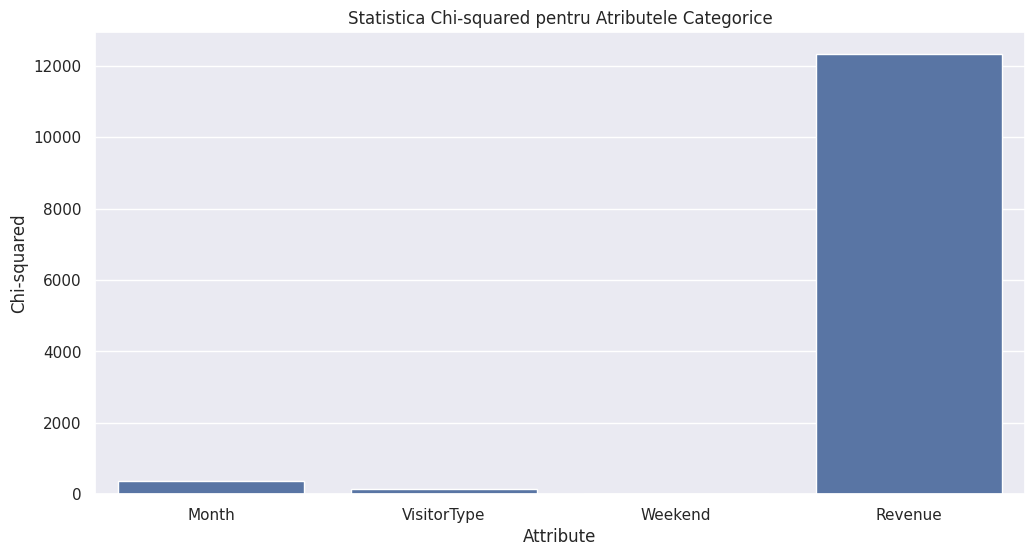

In [8]:
correlation_results_categorical = []

for attribute in categorical_attributes:
    contingency_table = pd.crosstab(df[attribute], df['Revenue'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    correlation_results_categorical.append({'Attribute': attribute, 'Chi-squared': chi2, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_categorical = pd.DataFrame(correlation_results_categorical)
print(correlation_df_categorical)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_categorical_attributes = correlation_df_categorical[correlation_df_categorical['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
sns.barplot(x='Attribute', y='Chi-squared', data=significant_categorical_attributes)
plt.title('Statistica Chi-squared pentru Atributele Categorice')
plt.show()


### Concluzia analizei p-value folosind Coeficientul de Point-Biserial si Testul Chi-squared
- Un p-value cat mai mic indica o corelare mai mare a atributului cu tinta de predictie
- Vom folosi p-valiue <= 0.05 ca valoare maxima admisibila pentru un atribut, pentru a-l considera relrevant in predictia noastra

# 3.2. Antrenarea și Evaluarea Algoritmilor de Predicție

#### Setting some variables needed for the comparison

In [9]:
# Plot X axis step
STEP_PERCENT=1.25
# Number of times to run the function
num_iterations = 10

## 3.2.1. Regresie Logistică

### 1. Implementare manuală

#### Regresia Logistica

In [10]:
clipped_value = 500

def split_dataset(X, T, train=.8):
    N = X.shape[0]
    N_train = int(round(N * train))
    N_test = N - N_train

    X_train, X_test = X[:N_train, :], X[N_train:, :]
    T_train, T_test = T[:N_train], T[N_train:]
    return X_train, T_train, X_test, T_test

def logistic(x):
    # Clip the input values to prevent overflow
    clipped_x = np.clip(x, -clipped_value, clipped_value)
    
    # Calculate the logistic function on the clipped values
    return 1 / (1 + np.exp(-clipped_x))

# Negative Log Likelihood - functia J(w)
def nll(Y, T):
    epsilon = 1e-15
    Y = np.clip(Y, epsilon, 1 - epsilon)
    return -np.mean(T * np.log(Y) + (1 - T) * np.log(1 - Y))

def accuracy(Y, T):
    predicted_labels = np.round(Y)
    correct_predictions = np.sum(predicted_labels == T)
    total_samples = len(T)
    return correct_predictions / total_samples

# Antrenati modelul logistic (ponderile W), executand epochs_no pasi din algoritmul de gradient descent
def train_logistic(X, T, lr=0.01, epochs_no=100):
    (N, D) = X.shape
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    W = np.random.randn(D + 1)

    for epoch in range(epochs_no):
        Y = logistic(np.dot(X_hat, W))
        gradient = np.dot(X_hat.T, (Y - T))
        W -= lr * gradient

    return W

# Calculati predictia Y a modelului logistic antrenat (ponderile W invatate)
def predict_logistic(X, W):
    X_hat = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    Y = logistic(np.dot(X_hat, W))
    return Y

def train_logistic_full(X, T, lr=0.01, learning_increase_percent=2.5, epochs_no=1000):
    (N, D) = X.shape
    X1 = np.concatenate([np.ones((N, 1)), X], axis=1)
    W = np.random.randn(D + 1)

    X_train, T_train, X_test, T_test = split_dataset(X1, T)
    
    train_acc, test_acc = [], []
    train_nll, test_nll = [], []
    W_trace = [W.copy()]

    for epoch in range(epochs_no):
        # Maresc learning rate-ul pt fiecare epoch
        lr = lr * (1 + learning_increase_percent / 100) 
        
        Y_train = logistic(X_train @ W)
        
        gradient = np.transpose(X_train) @ (Y_train-T_train)/N
        W -= lr * gradient

        logits = np.dot(X_test, W)
        Y_test = 1. / (1. + np.exp(-np.clip(logits, -clipped_value, clipped_value)))

        train_acc.append(accuracy(Y_train, T_train))
        test_acc.append(accuracy(Y_test, T_test))
        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))
        W_trace.append(W.copy())

    return W, train_acc, test_acc, train_nll, test_nll, W_trace

#### Preprocesarea datelor

In [11]:
def preprocess_data(df):
    # Split set de date în caracteristici (X) și variabilă țintă (y)
    X = df.drop('Revenue', axis=1)
    y = df['Revenue'] # Revenue este boolean ( 0 / 1)
    
    # Conversia variabilelor categorice în formă numerică
    label_encoder = LabelEncoder()
    categorical_columns = ['Month', 'VisitorType', 'Weekend']
    for column in categorical_columns:
        X[column] = label_encoder.fit_transform(X[column])

    return X, y

#### Functie pentru plotting

In [12]:
# Definim o functie ajutatoare pentru plotting
def plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent=2.5):
    # Step_percent = 5 <==> 100 / 5 == 20 X points on the plot
    epochs_no = len(train_acc)
    step = round(epochs_no * step_percent / 100)
    # If step is 0, we will set minimum default step for the plotting
    if step == 0:
        step = 1
    fig, (ax1, ax2) = plt.subplots(2, 1)

    # Plotting accuracy evolution
    ax1.plot(range(0, epochs_no, step), train_acc[::step], sns.xkcd_rgb["green"], label="Train Accuracy")
    ax1.plot(range(0, epochs_no, step), test_acc[::step], sns.xkcd_rgb["red"], label="Test Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    # Plotting negative log likelihood evolution
    ax2.plot(range(0, epochs_no, step), train_nll[::step], sns.xkcd_rgb["green"], label="Train NLL")
    ax2.plot(range(0, epochs_no, step), test_nll[::step], sns.xkcd_rgb["red"], label="Test NLL")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1)

    # Adding title with scaler information
    plt.suptitle(f'Evolution with Scaler: {scaler}')
    plt.show()
    
    return (ax1, ax2)

In [13]:
# Function to print metrics for a specific measure (e.g., accuracy, precision, recall, f1_score)
def print_metrics(metric_name, results_dict, num_iterations):
    for scaler_name, metric_list in results_dict.items():
        mean_metric = np.mean(metric_list)
        median_metric = np.median(metric_list)
        variance_metric = np.var(metric_list)
        min_metric = np.min(metric_list)
        max_metric = np.max(metric_list)

        print(f"\nMetrics for {metric_name} with {scaler_name} after {num_iterations} runs:")
        print(f"Mean {metric_name}: {mean_metric}")
        print(f"Median {metric_name}: {median_metric}")
        print(f"Variance {metric_name}: {variance_metric}")
        print(f"Min {metric_name}: {min_metric}")
        print(f"Max {metric_name}: {max_metric}")

#### Datele de fitting ale modelului

In [14]:
EPOCHS_NO = 200
LR = 0.035
LEARNING_INCREASE_PERCENT = 1

### Scalers

In [15]:
# Normalizarea datelor (Scalare)
scalers = {
        'MinMaxScaler': MinMaxScaler(),
        'StandardScaler': StandardScaler(),
        'RobustScaler': RobustScaler()
}

#### Standard Scaler = (x - mean) / standard deviation

Descriere: Standard Scaler standardizează caracteristicile eliminând media și scalând la deviația standard.
Transformă datele astfel încât să aibă o medie de 0 și o deviație standard de 1.
Este potrivit atunci când datele par a urma o distribuție gaussiană.

#### Robust Scaler = (x - median) / interquartile range

Descriere: Robust Scaler este robust în fața valorilor extreme și este potrivit atunci când există outlieri în date.
Se bazează pe mediană și pe intervalul interquartil (IQR) pentru scalare.
Mediană și IQR sunt mai puțin afectate de outlieri decât media și deviația standard.

#### MinMax Scaler = (x - min) / (max - min)

Descriere: Min-Max Scaler redimensionează caracteristicile la un interval specific, de obicei [0, 1]. 
Transformă datele printr-o mapare liniară către acest interval. 
Este sensibil la valori extreme și este o alegere bună atunci când se dorește ca datele să fie într-un anumit interval.

### Concluzii despre Scalers

Standard Scaler: Atunci când datele par a avea o distribuție gaussiană și nu conțin outlieri semnificativi.

Robust Scaler: Atunci când datele conțin outlieri semnificativi sau atunci când nu poți presupune că datele tale sunt distribuite normal.

Min-Max Scaler: Atunci când vrei ca datele să fie într-un anumit interval și nu ai de-a face cu outlieri care să influențeze procesul de scalare.

In [16]:
def logistic_regression_manual(X, y, lr=0.01, learning_increase_percent=2.5, epochs_no=100, step_percent=100):
    # Modify the dataset to include only the features we consider relevant to our target
    # Lista cu numele caracteristicilor selectate pe baza p-value-ului
    selected_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                     'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
                     'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Month', 'VisitorType', 'Weekend']
    X_selected = X[selected_features]
    
    # Iterate over the scalers
    for scaler_name, scaler in scalers.items():
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Scalarea datelor de antrenare
        X_train_scaled = scaler.fit_transform(X_train)

        # Antrenarea modelului logistic
        W, train_acc, test_acc, train_nll, test_nll, W_trace = train_logistic_full(X_train_scaled, y_train, lr=lr, epochs_no=epochs_no)

        # Evaluarea modelului pe setul de testare
        X_test_scaled = scaler.transform(X_test)
        Y_test = predict_logistic(X_test_scaled, W)

        # Evaluare metrici pe setul de testare
        precision = precision_score(y_test, np.round(Y_test))
        recall = recall_score(y_test, np.round(Y_test))
        f1 = f1_score(y_test, np.round(Y_test))
        test_accuracy = accuracy(Y_test, y_test)

        # Afișare și salvare metrici
        print(f"Acuratete folosind {scaler_name}: {test_accuracy}")
        print(f"Precision folosind {scaler_name}: {precision}")
        print(f"Recall folosind {scaler_name}: {recall}")
        print(f"F1 Score folosind {scaler_name}: {f1}")
        
        # Save metric values in dictionaries
        if scaler_name not in precision_results:
            precision_results[scaler_name] = []
        precision_results[scaler_name].append(precision)
        if scaler_name not in recall_results:
            recall_results[scaler_name] = []
        recall_results[scaler_name].append(recall)
        if scaler_name not in f1_score_results:
            f1_score_results[scaler_name] = []
        f1_score_results[scaler_name].append(f1)
        if scaler_name not in accuracy_results:
            accuracy_results[scaler_name] = []
        accuracy_results[scaler_name].append(test_accuracy)

        # Vizualizare evolutie
        plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent)
        
        # Eliberare memorie
        del X_train, X_train_scaled, X_test_scaled, Y_test, W, train_acc, test_acc, train_nll, test_nll, W_trace

#### Rulam de 10 ori algoritmul pe sample-uri random ale datasetului initial

Training dataset size: 12330
Number of features: 17

RULAREA NUMARUL 1
Acuratete folosind MinMaxScaler: 0.6682887266828873
Precision folosind MinMaxScaler: 0.06140350877192982
Recall folosind MinMaxScaler: 0.06698564593301436
F1 Score folosind MinMaxScaler: 0.06407322654462244


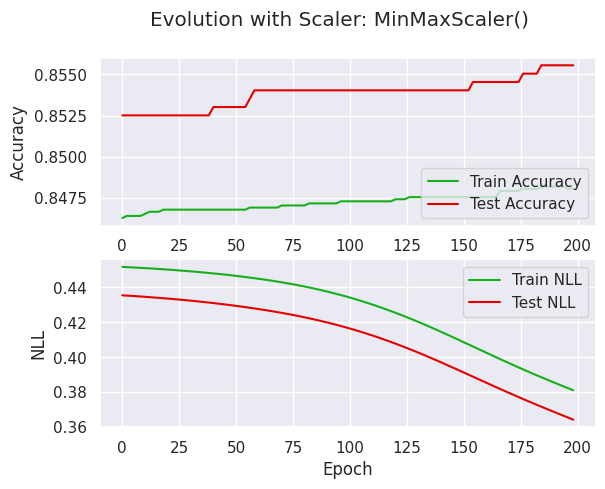

Acuratete folosind StandardScaler: 0.3248175182481752
Precision folosind StandardScaler: 0.07399864222674814
Recall folosind StandardScaler: 0.2658536585365854
F1 Score folosind StandardScaler: 0.11577270313329795


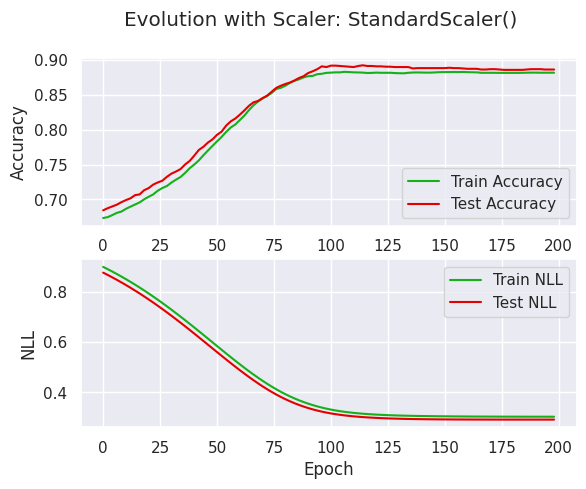

Acuratete folosind RobustScaler: 0.6253041362530414
Precision folosind RobustScaler: 0.1221264367816092
Recall folosind RobustScaler: 0.2135678391959799
F1 Score folosind RobustScaler: 0.1553930530164534


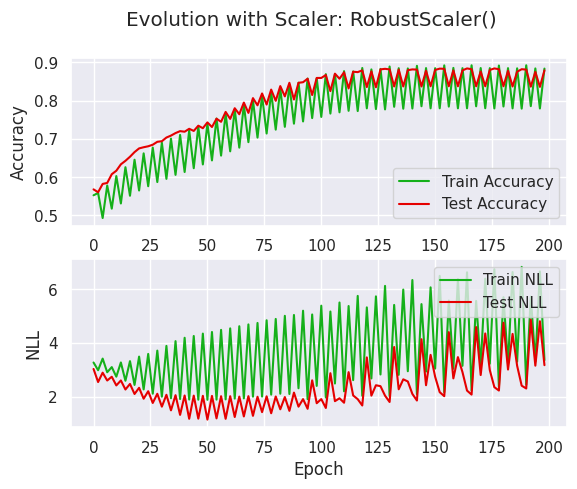


RULAREA NUMARUL 2
Acuratete folosind MinMaxScaler: 0.7854825628548256
Precision folosind MinMaxScaler: 0.15498154981549817
Recall folosind MinMaxScaler: 0.12280701754385964
F1 Score folosind MinMaxScaler: 0.1370309951060359


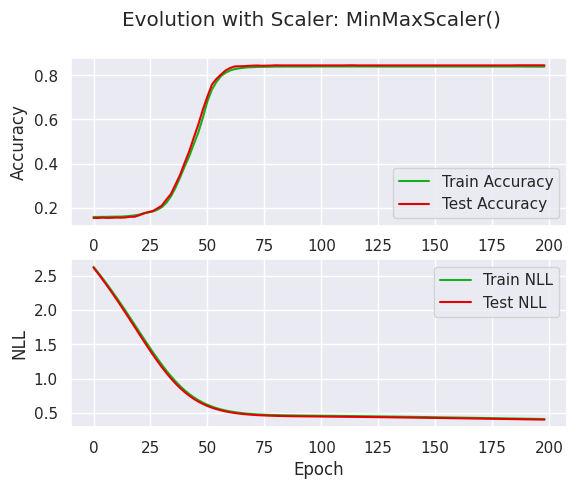

Acuratete folosind StandardScaler: 0.4083536090835361
Precision folosind StandardScaler: 0.11015736766809728
Recall folosind StandardScaler: 0.4173441734417344
F1 Score folosind StandardScaler: 0.17430673457838144


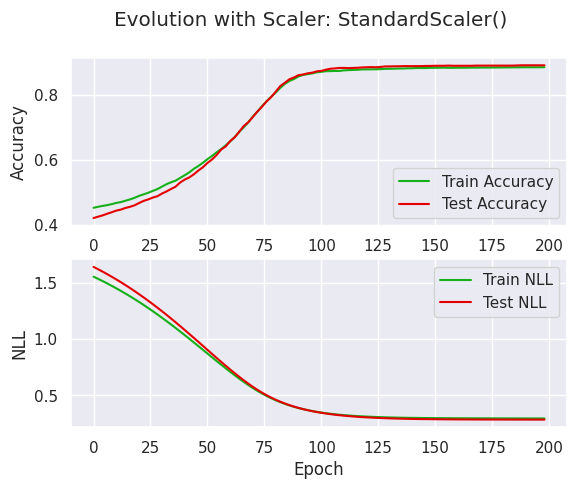

Acuratete folosind RobustScaler: 0.47120843471208435
Precision folosind RobustScaler: 0.045408678102926335
Recall folosind RobustScaler: 0.11166253101736973
F1 Score folosind RobustScaler: 0.06456241032998564


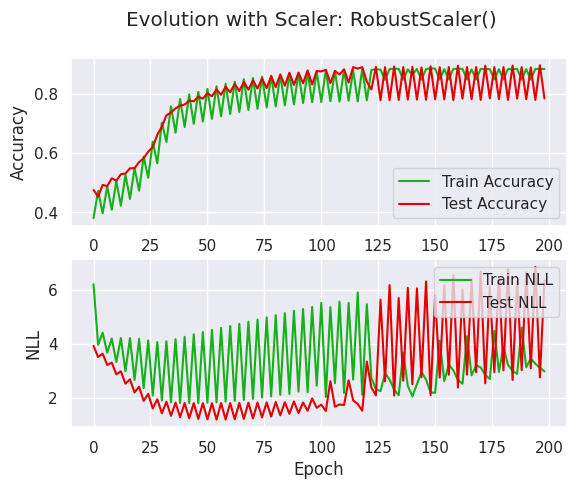


RULAREA NUMARUL 3
Acuratete folosind MinMaxScaler: 0.7725060827250608
Precision folosind MinMaxScaler: 0.06542056074766354
Recall folosind MinMaxScaler: 0.037333333333333336
F1 Score folosind MinMaxScaler: 0.04753820033955857


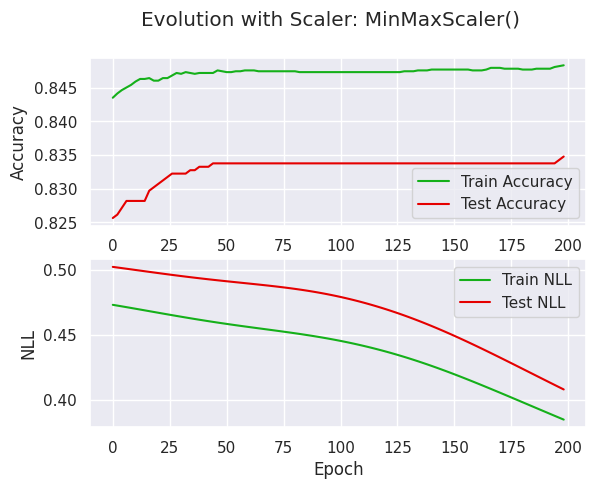

Acuratete folosind StandardScaler: 0.3284671532846715
Precision folosind StandardScaler: 0.067854694996573
Recall folosind StandardScaler: 0.25063291139240507
F1 Score folosind StandardScaler: 0.10679611650485439


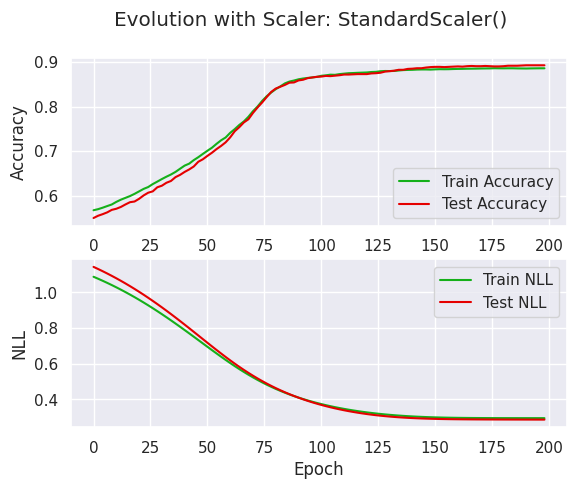

Acuratete folosind RobustScaler: 0.4626926196269262
Precision folosind RobustScaler: 0.0586565752128666
Recall folosind RobustScaler: 0.15816326530612246
F1 Score folosind RobustScaler: 0.08557625948930296


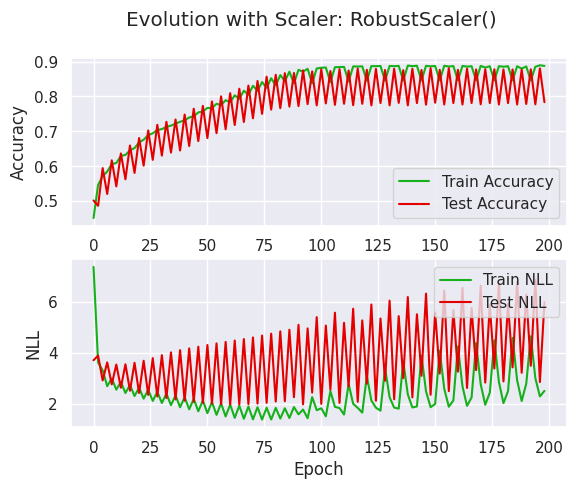


RULAREA NUMARUL 4
Acuratete folosind MinMaxScaler: 0.7818329278183292
Precision folosind MinMaxScaler: 0.07643312101910828
Recall folosind MinMaxScaler: 0.02962962962962963
F1 Score folosind MinMaxScaler: 0.042704626334519574


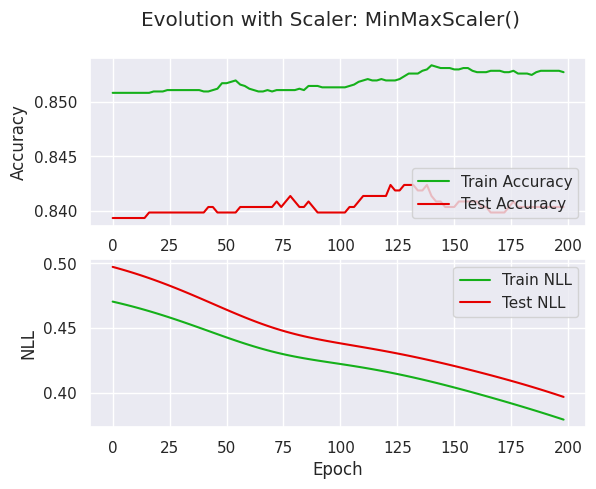

Acuratete folosind StandardScaler: 0.3264395782643958
Precision folosind StandardScaler: 0.05886379192334018
Recall folosind StandardScaler: 0.23118279569892472
F1 Score folosind StandardScaler: 0.09383524277141299


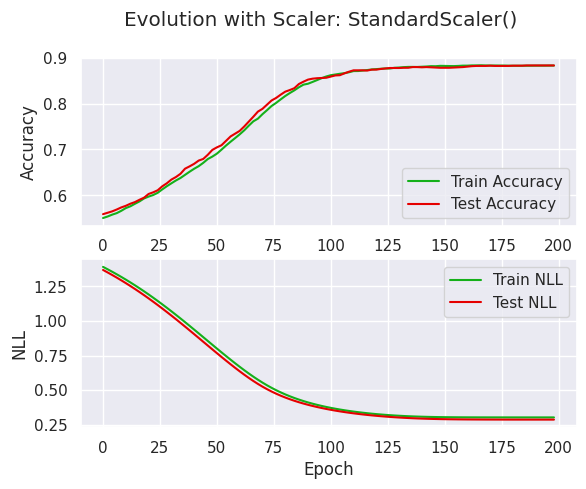

Acuratete folosind RobustScaler: 0.6184103811841039
Precision folosind RobustScaler: 0.09781021897810219
Recall folosind RobustScaler: 0.1717948717948718
F1 Score folosind RobustScaler: 0.12465116279069766


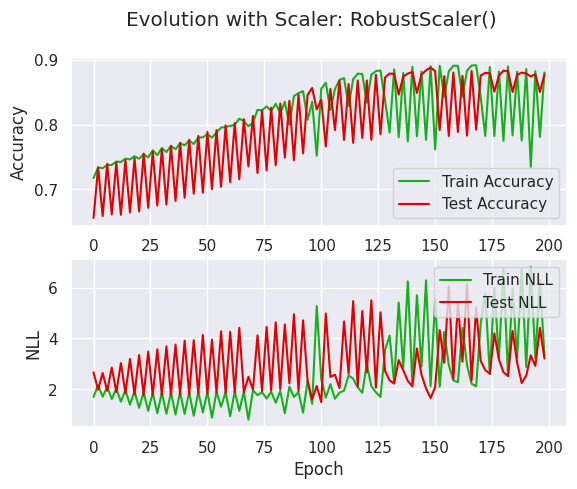


RULAREA NUMARUL 5
Acuratete folosind MinMaxScaler: 0.8418491484184915
Precision folosind MinMaxScaler: 0.2571428571428571
Recall folosind MinMaxScaler: 0.024128686327077747
F1 Score folosind MinMaxScaler: 0.044117647058823525


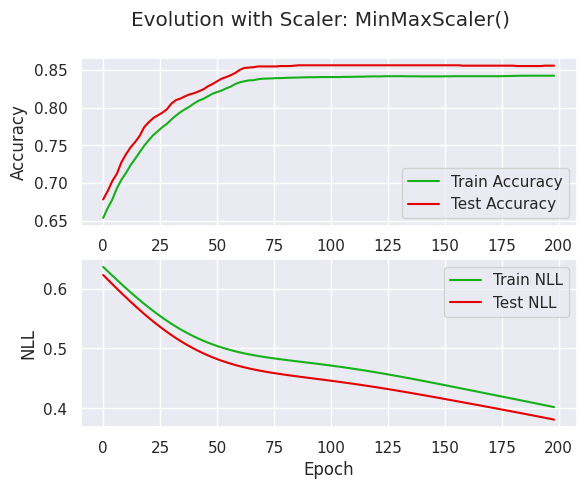

Acuratete folosind StandardScaler: 0.3309002433090024
Precision folosind StandardScaler: 0.052742616033755275
Recall folosind StandardScaler: 0.1984126984126984
F1 Score folosind StandardScaler: 0.08333333333333334


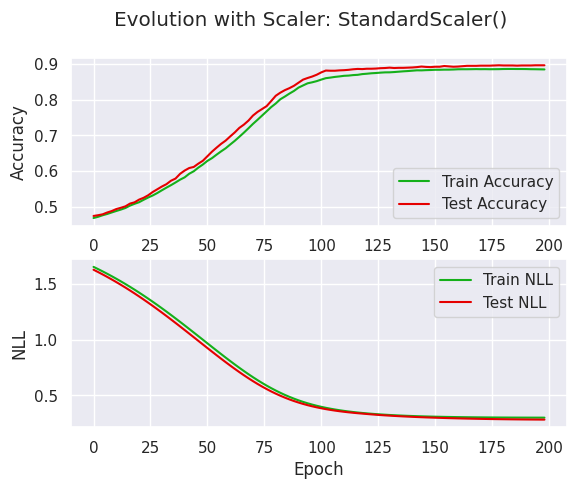

Acuratete folosind RobustScaler: 0.47769667477696676
Precision folosind RobustScaler: 0.057368941641938676
Recall folosind RobustScaler: 0.1475826972010178
F1 Score folosind RobustScaler: 0.08262108262108263


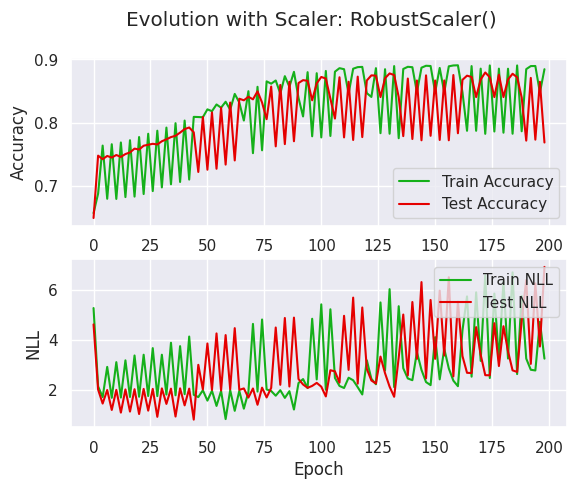


RULAREA NUMARUL 6
Acuratete folosind MinMaxScaler: 0.8248175182481752
Precision folosind MinMaxScaler: 0.24705882352941178
Recall folosind MinMaxScaler: 0.05398457583547558
F1 Score folosind MinMaxScaler: 0.08860759493670886


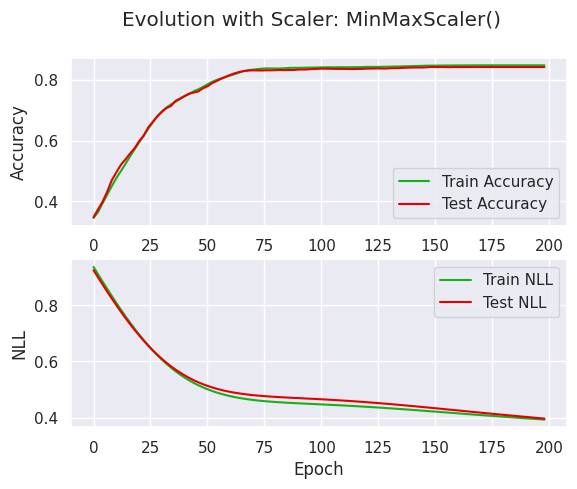

Acuratete folosind StandardScaler: 0.3264395782643958
Precision folosind StandardScaler: 0.06571815718157181
Recall folosind StandardScaler: 0.2559366754617414
F1 Score folosind StandardScaler: 0.1045822102425876


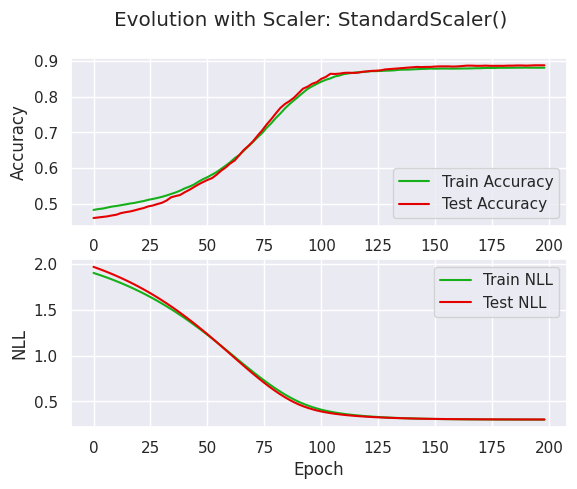

Acuratete folosind RobustScaler: 0.45742092457420924
Precision folosind RobustScaler: 0.01026694045174538
Recall folosind RobustScaler: 0.026041666666666668
F1 Score folosind RobustScaler: 0.014727540500736375


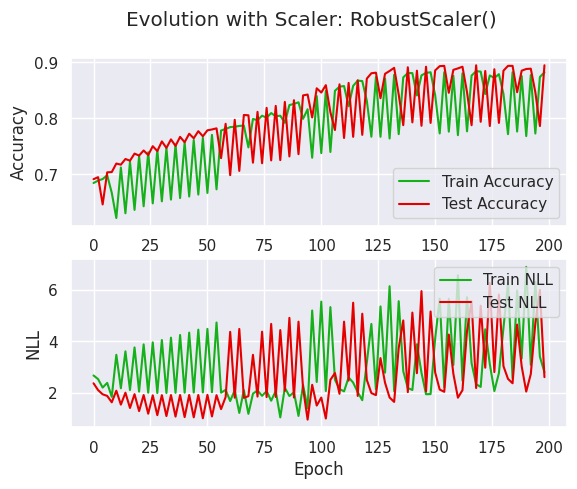


RULAREA NUMARUL 7
Acuratete folosind MinMaxScaler: 0.781021897810219
Precision folosind MinMaxScaler: 0.0903954802259887
Recall folosind MinMaxScaler: 0.04050632911392405
F1 Score folosind MinMaxScaler: 0.055944055944055944


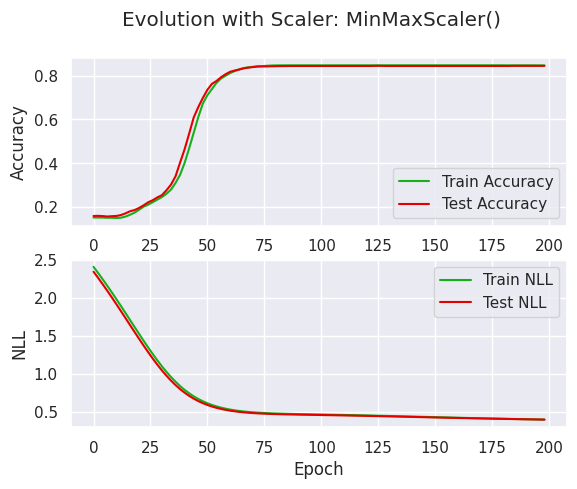

Acuratete folosind StandardScaler: 0.4505271695052717
Precision folosind StandardScaler: 0.14222549742078114
Recall folosind StandardScaler: 0.5026041666666666
F1 Score folosind StandardScaler: 0.22171165996553707


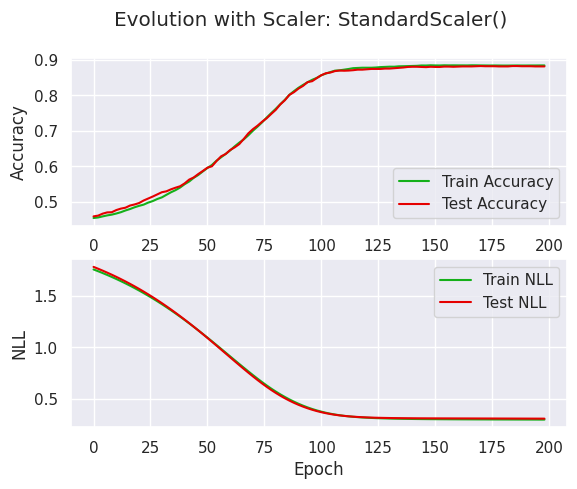

Acuratete folosind RobustScaler: 0.6532846715328468
Precision folosind RobustScaler: 0.02766798418972332
Recall folosind RobustScaler: 0.03713527851458886
F1 Score folosind RobustScaler: 0.031710079275198186


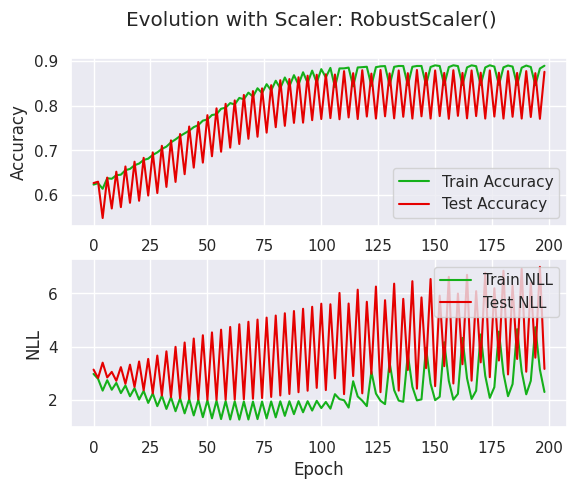


RULAREA NUMARUL 8
Acuratete folosind MinMaxScaler: 0.3353609083536091
Precision folosind MinMaxScaler: 0.11863391252246855
Recall folosind MinMaxScaler: 0.5409836065573771
F1 Score folosind MinMaxScaler: 0.1945945945945946


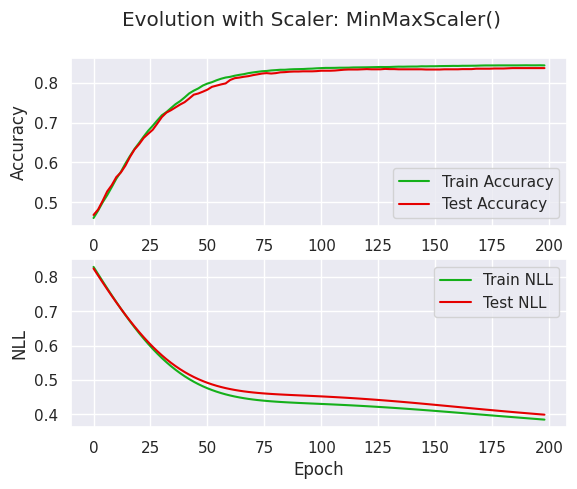

Acuratete folosind StandardScaler: 0.4286293592862936
Precision folosind StandardScaler: 0.13783403656821377
Recall folosind StandardScaler: 0.5171503957783641
F1 Score folosind StandardScaler: 0.21765685730149917


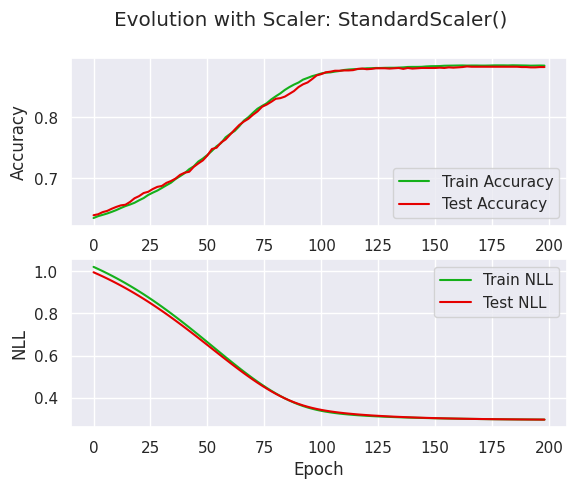

Acuratete folosind RobustScaler: 0.4630981346309814
Precision folosind RobustScaler: 0.01919191919191919
Recall folosind RobustScaler: 0.051075268817204304
F1 Score folosind RobustScaler: 0.027900146842878122


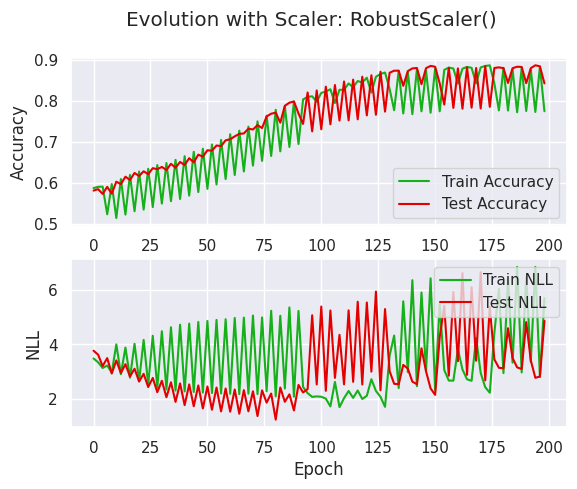


RULAREA NUMARUL 9
Acuratete folosind MinMaxScaler: 0.8381995133819952
Precision folosind MinMaxScaler: 0.5
Recall folosind MinMaxScaler: 0.002506265664160401
F1 Score folosind MinMaxScaler: 0.004987531172069825


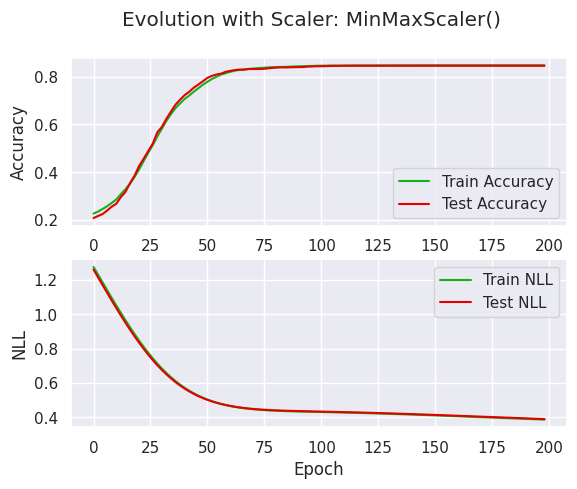

Acuratete folosind StandardScaler: 0.40875912408759124
Precision folosind StandardScaler: 0.11331444759206799
Recall folosind StandardScaler: 0.4371584699453552
F1 Score folosind StandardScaler: 0.17997750281214847


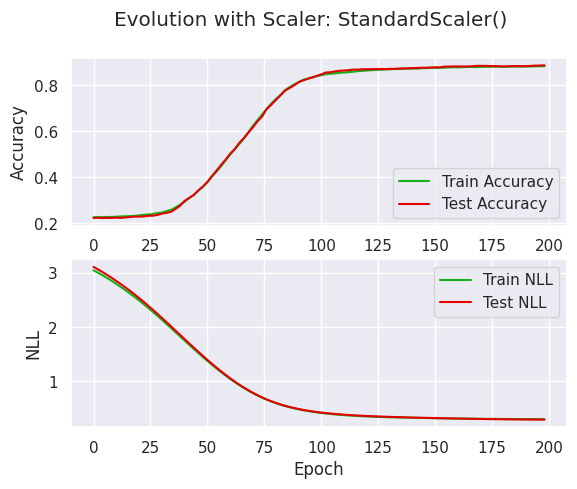

Acuratete folosind RobustScaler: 0.5348742903487429
Precision folosind RobustScaler: 0.01703800786369594
Recall folosind RobustScaler: 0.03170731707317073
F1 Score folosind RobustScaler: 0.02216538789428815


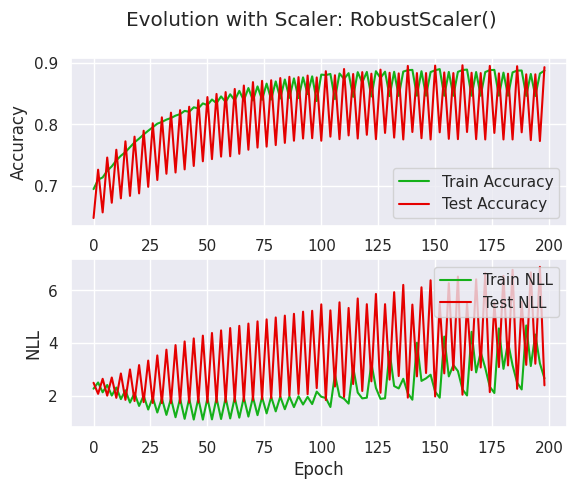


RULAREA NUMARUL 10
Acuratete folosind MinMaxScaler: 0.3791565287915653
Precision folosind MinMaxScaler: 0.13682219419924338
Recall folosind MinMaxScaler: 0.5725593667546174
F1 Score folosind MinMaxScaler: 0.22086513994910942


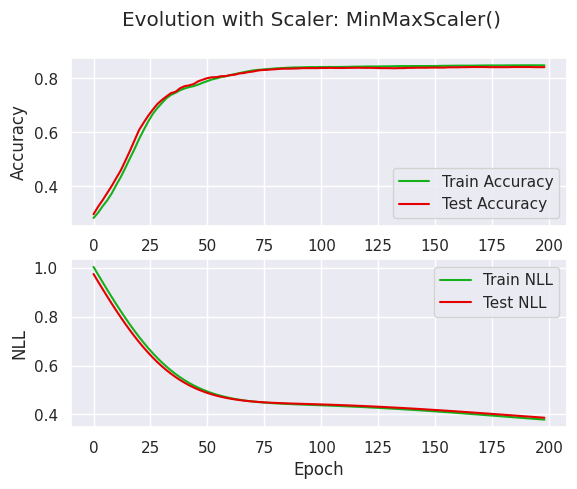

Acuratete folosind StandardScaler: 0.3264395782643958
Precision folosind StandardScaler: 0.05459571527297857
Recall folosind StandardScaler: 0.21236559139784947
F1 Score folosind StandardScaler: 0.08686091258933479


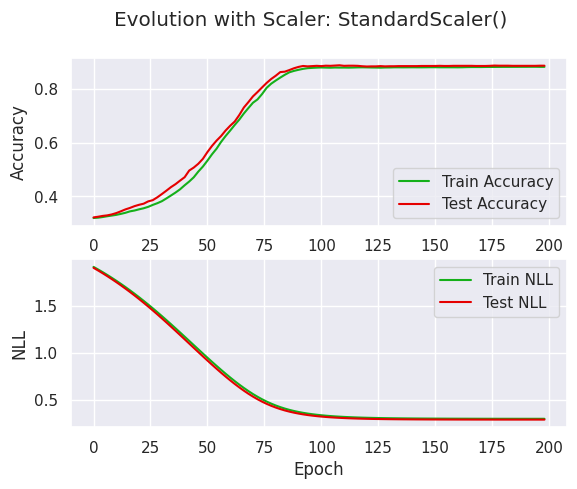

Acuratete folosind RobustScaler: 0.44931062449310627
Precision folosind RobustScaler: 0.025540275049115914
Recall folosind RobustScaler: 0.0663265306122449
F1 Score folosind RobustScaler: 0.03687943262411347


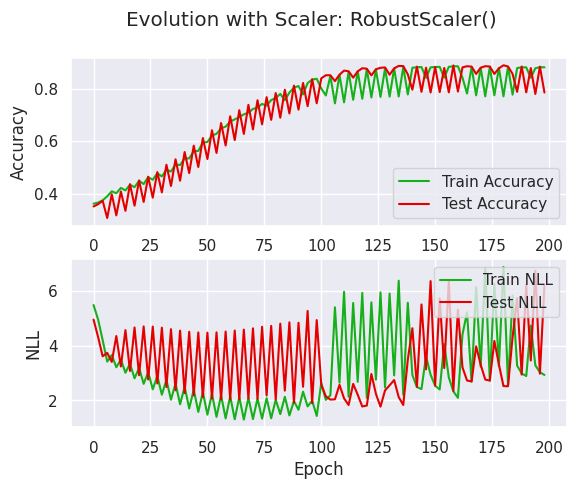

In [17]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    # Preprocesarea datelor
    X, y = preprocess_data(df.copy())

    print(f"\nRULAREA NUMARUL {iteration + 1}")
    # Apelul funcției cu datele specifice
    logistic_regression_manual(X,y,lr=LR,learning_increase_percent=LEARNING_INCREASE_PERCENT,epochs_no=EPOCHS_NO,step_percent=STEP_PERCENT)
    del X, y

#### Conclusion for the manual logistic regression

In [18]:
print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

del precision_results, recall_results, f1_score_results, accuracy_results


FINAL STATISTICS

ACCURACY

Metrics for Accuracy with MinMaxScaler after 10 runs:
Mean Accuracy: 0.7008515815085159
Median Accuracy: 0.7814274128142742
Variance Accuracy: 0.031752582897067595
Min Accuracy: 0.3353609083536091
Max Accuracy: 0.8418491484184915

Metrics for Accuracy with StandardScaler after 10 runs:
Mean Accuracy: 0.36597729115977284
Median Accuracy: 0.32968369829683697
Variance Accuracy: 0.0023721229976668913
Min Accuracy: 0.3248175182481752
Max Accuracy: 0.4505271695052717

Metrics for Accuracy with RobustScaler after 10 runs:
Mean Accuracy: 0.5213300892133009
Median Accuracy: 0.4744525547445255
Variance Accuracy: 0.005834719582921406
Min Accuracy: 0.44931062449310627
Max Accuracy: 0.6532846715328468

PRECISION

Metrics for Precision with MinMaxScaler after 10 runs:
Mean Precision: 0.17082920079741692
Median Precision: 0.12772805336085596
Variance Precision: 0.016421155711363683
Min Precision: 0.06140350877192982
Max Precision: 0.5

Metrics for Precision with StandardS

### 2. Implementare folosind scikit-learn

In [19]:
def logistic_regression_scikit_learn(X, y, step_percent=100):
    # Iterate over the scalers
    for scaler_name, scaler in scalers.items():
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Scalarea datelor de antrenare
        X_train_scaled = scaler.fit_transform(X_train)
    
        # Create and train the logistic regression model
        model = LogisticRegression(random_state=None, max_iter=5000)
        model.fit(X_train_scaled, y_train)

        # Make predictions on the test set
        X_test_scaled = scaler.transform(X_test)
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate the model
        test_accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Afișare și salvare metrici
        print(f"Acuratete folosind {scaler_name}: {test_accuracy}")
        print(f"Precision folosind {scaler_name}: {precision}")
        print(f"Recall folosind {scaler_name}: {recall}")
        print(f"F1 Score folosind {scaler_name}: {f1}")
        
        # Save metric values in dictionaries
        if scaler_name not in precision_results:
            precision_results[scaler_name] = []
        precision_results[scaler_name].append(precision)
        if scaler_name not in recall_results:
            recall_results[scaler_name] = []
        recall_results[scaler_name].append(recall)
        if scaler_name not in f1_score_results:
            f1_score_results[scaler_name] = []
        f1_score_results[scaler_name].append(f1)
        if scaler_name not in accuracy_results:
            accuracy_results[scaler_name] = []
        accuracy_results[scaler_name].append(test_accuracy)

        # Clean up variables
        del model

    # Clean up remaining variables
    del X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

#### Rulam de 10 ori algoritmul pe sample-uri random ale datasetului initial

In [20]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    X, y = preprocess_data(df.copy())

    print(f"\nRUN NUMBER {iteration + 1}")
    # Apelul funcției cu datele specifice
    logistic_regression_scikit_learn(X, y, step_percent=STEP_PERCENT)
    del X, y

Training dataset size: 12330
Number of features: 17

RUN NUMBER 1
Acuratete folosind MinMaxScaler: 0.8637469586374696
Precision folosind MinMaxScaler: 0.7727272727272727
Recall folosind MinMaxScaler: 0.25
F1 Score folosind MinMaxScaler: 0.37777777777777777
Acuratete folosind StandardScaler: 0.8888888888888888
Precision folosind StandardScaler: 0.7849462365591398
Recall folosind StandardScaler: 0.38421052631578945
F1 Score folosind StandardScaler: 0.5159010600706714
Acuratete folosind RobustScaler: 0.8901054339010543
Precision folosind RobustScaler: 0.7383177570093458
Recall folosind RobustScaler: 0.42359249329758714
F1 Score folosind RobustScaler: 0.5383304940374787

RUN NUMBER 2
Acuratete folosind MinMaxScaler: 0.8669910786699108
Precision folosind MinMaxScaler: 0.8248175182481752
Recall folosind MinMaxScaler: 0.2709832134292566
F1 Score folosind MinMaxScaler: 0.40794223826714804
Acuratete folosind StandardScaler: 0.8844282238442822
Precision folosind StandardScaler: 0.76
Recall folos

#### Conclusion for the scikit-learn logistic regression

In [21]:
print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

# Clean up remaining variables
del precision_results, recall_results, f1_score_results, accuracy_results


FINAL STATISTICS

ACCURACY

Metrics for Accuracy with MinMaxScaler after 10 runs:
Mean Accuracy: 0.8705596107055961
Median Accuracy: 0.8706407137064072
Variance Accuracy: 2.8737957059480186e-05
Min Accuracy: 0.8617193836171938
Max Accuracy: 0.8779399837793999

Metrics for Accuracy with StandardScaler after 10 runs:
Mean Accuracy: 0.8856447688564477
Median Accuracy: 0.885036496350365
Variance Accuracy: 2.0719744732744833e-05
Min Accuracy: 0.8775344687753447
Max Accuracy: 0.8953771289537713

Metrics for Accuracy with RobustScaler after 10 runs:
Mean Accuracy: 0.8869018653690187
Median Accuracy: 0.8844282238442822
Variance Accuracy: 3.704723246698513e-05
Min Accuracy: 0.8791565287915653
Max Accuracy: 0.8982157339821574

PRECISION

Metrics for Precision with MinMaxScaler after 10 runs:
Mean Precision: 0.7607897986224401
Median Precision: 0.7615740740740741
Variance Precision: 0.00080343226194224
Min Precision: 0.7251908396946565
Max Precision: 0.8248175182481752

Metrics for Precision wit

## 3.2.2. Arbore de Decizie

### 1. Implementare folosind scikit-learn

In [22]:
def decision_tree_scikit_learn(X, y, step_percent=100):
    # Iterate over the scalers
    for scaler_name, scaler in scalers.items():
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Scalarea datelor de antrenare
        X_train_scaled = scaler.fit_transform(X_train)
    
        # Create and train the decision tree model
        model = DecisionTreeClassifier(random_state=None)
        model.fit(X_train_scaled, y_train)

        # Make predictions on the test set
        X_test_scaled = scaler.transform(X_test)
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate the model
        test_accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Afișare și salvare metrici
        print(f"Acuratete folosind {scaler_name}: {test_accuracy}")
        print(f"Precision folosind {scaler_name}: {precision}")
        print(f"Recall folosind {scaler_name}: {recall}")
        print(f"F1 Score folosind {scaler_name}: {f1}")
        
        # Save metric values in dictionaries
        if scaler_name not in precision_results:
            precision_results[scaler_name] = []
        precision_results[scaler_name].append(precision)
        if scaler_name not in recall_results:
            recall_results[scaler_name] = []
        recall_results[scaler_name].append(recall)
        if scaler_name not in f1_score_results:
            f1_score_results[scaler_name] = []
        f1_score_results[scaler_name].append(f1)
        if scaler_name not in accuracy_results:
            accuracy_results[scaler_name] = []
        accuracy_results[scaler_name].append(test_accuracy)

        # Clean up variables
        del model

    # Clean up remaining variables
    del X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

#### Rulam de 10 ori algoritmul pe sample-uri random ale datasetului initial

In [23]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    X, y = preprocess_data(df.copy())

    print(f"\nRUN NUMBER {iteration + 1}")
    # Apelul funcției cu datele specifice
    decision_tree_scikit_learn(X, y, step_percent=STEP_PERCENT)
    del X, y

Training dataset size: 12330
Number of features: 17

RUN NUMBER 1
Acuratete folosind MinMaxScaler: 0.8592862935928629
Precision folosind MinMaxScaler: 0.5373493975903615
Recall folosind MinMaxScaler: 0.58994708994709
F1 Score folosind MinMaxScaler: 0.562421185372005
Acuratete folosind StandardScaler: 0.8629359286293593
Precision folosind StandardScaler: 0.5475578406169666
Recall folosind StandardScaler: 0.568
F1 Score folosind StandardScaler: 0.5575916230366492
Acuratete folosind RobustScaler: 0.8682076236820763
Precision folosind RobustScaler: 0.5510204081632653
Recall folosind RobustScaler: 0.5917808219178082
F1 Score folosind RobustScaler: 0.570673712021136

RUN NUMBER 2
Acuratete folosind MinMaxScaler: 0.8661800486618005
Precision folosind MinMaxScaler: 0.5529715762273901
Recall folosind MinMaxScaler: 0.5768194070080862
F1 Score folosind MinMaxScaler: 0.5646437994722954
Acuratete folosind StandardScaler: 0.864963503649635
Precision folosind StandardScaler: 0.5635491606714629
Recall

#### Conclusion for the scikit-learn logistic regression¶

In [24]:
print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

# Clean up remaining variables
del precision_results, recall_results, f1_score_results, accuracy_results


FINAL STATISTICS

ACCURACY

Metrics for Accuracy with MinMaxScaler after 10 runs:
Mean Accuracy: 0.8629359286293592
Median Accuracy: 0.8623276561232766
Variance Accuracy: 2.0292194444609033e-05
Min Accuracy: 0.856853203568532
Max Accuracy: 0.8722627737226277

Metrics for Accuracy with StandardScaler after 10 runs:
Mean Accuracy: 0.8621654501216545
Median Accuracy: 0.8600973236009732
Variance Accuracy: 4.582845761562429e-05
Min Accuracy: 0.8532035685320357
Max Accuracy: 0.8767234387672344

Metrics for Accuracy with RobustScaler after 10 runs:
Mean Accuracy: 0.8588402270884024
Median Accuracy: 0.8594890510948905
Variance Accuracy: 2.4845605013257467e-05
Min Accuracy: 0.8503649635036497
Max Accuracy: 0.8682076236820763

PRECISION

Metrics for Precision with MinMaxScaler after 10 runs:
Mean Precision: 0.5550085478016517
Median Precision: 0.5509423098528254
Variance Precision: 0.0003295061316721232
Min Precision: 0.5301507537688442
Max Precision: 0.5888324873096447

Metrics for Precision w

### 2. Implementare manuală

## Metricile de evaluare a modelului

#### ACCURACY = (True Positives + True Negatives) / Total Examples

Definitie: Acuratețea este o măsură a proporției de exemple clasificate corect de model din totalul de exemple.
Este dată de raportul dintre numărul de exemple clasificate corect (True Positives + True Negatives) și totalul de exemple.
Utilitate: Acuratețea este utilă în evaluarea generală a performanței modelului, 
dar poate fi înșelătoare în cazul seturilor de date cu dezechilibre între clase (imbalanced datasets).


#### PRECISION = True Positives / (True Positivies + False Positives)

​Definiție: Precizia este măsura proporției de exemple pozitive identificate corect de model din totalul de exemple clasificate ca pozitive.
Este dată de raportul dintre True Positives și suma dintre True Positives și False Positives.
Utilitate: Precizia indică cât de "precis" este modelul atunci când clasifică exemplele pozitive.
Este importantă în situațiile în care costurile pentru clasificarea greșită a unui exemplu pozitiv sunt ridicate.

#### RECALL = True Positives / (True Positives + False Negatives)

Definiție: Recuperarea (sau Sensitivity) este măsura proporției de exemple pozitive identificate corect de model din totalul de exemple pozitive.
Este dată de raportul dintre True Positives și suma dintre True Positives și False Negatives.
Utilitate: Recuperarea indică cât de bine modelul identifică toate exemplele pozitive. 
Este importantă atunci când nu doriți să ratați exemple pozitive și costurile pentru clasificarea greșită a unui exemplu negativ nu sunt prea mari.

#### F1 = 2 x Precision x Recall / (Precision + Recall)

Definiție: Scorul F1 este media armonică dintre precizie și recuperare (recall). 
A fost conceput pentru a oferi o măsură echilibrată între cele două.
Utilitate: Scorul F1 este util în situațiile în care vă interesează un echilibru între precizie și recuperare.
Este deosebit de util în scenariile cu seturi de date dezechilibrate.

# Concluzii

Observam rezultate impartite intre cei 2 algoritmi (variantele implementate cu ajutorul bibliotecii scikit-learn). 
Consider ca metricile cele mai importante sunt Acuratetea predictiei si F1.
Logistic Regression reuseste acuratetea predictiei putin mai mare,
dar ca trade-off observam ca nu este la fel de stabil ca Decision Tree Clasifier, care obtine F1 mai bun cu 35%-40%.